# Numerical Optimization of Univariate Functions
Most estimation procedures involve maximization of some function, e.g.,
likelihood functions or (weighted) squared moment conditions. The
purpose of this week's exercise is to introduce the *numerical
procedures which are used to maximize the objective function* for
various $M$-estimators: Maximum Likelihood (ML), Least Absolute
Deviations (LAD), etc.

Knowing and being able to apply these procedures can help you answer 
questions like: What can be done if the
algorithm does not converge? What can be done in order to speed up the
convergence? Did I find the maximum or something else? Is the model
identified? Hence, a minimum knowledge about numerical optimization is
critical for the applied researcher.


In [1]:
import w6_estimation as est 
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

%load_ext autoreload
%autoreload 2

# Theory: Iterative Maximization Algorithm

The maximization algorithms in this course are all *iterative* in the sense that they start from some initial guess of the parameter, $\boldsymbol{\theta}_0$, specified by the researcher. At each iteration, the algorithm moves to a new value of the parameters $\boldsymbol{\theta}$ at which the likelihood function, $\ell(\boldsymbol{\theta})$, is higher than at the previous value of $\boldsymbol{\theta}$. 

Note that the subscripts are used in this context to express how many iterations the algorithm has run over. We denote the current value of $\boldsymbol{\theta}$ as $\boldsymbol{\theta}_t$, which is attained after $t$ iterations from the starting values $\boldsymbol{\theta}_0$. The question is then how to determine the best value of $\boldsymbol{\theta}_{t+1}$ given $\boldsymbol{\theta}_t$?

---

## Newton-Raphson (N-R): Matrix Notation

To determine the best value of $\boldsymbol{\theta}_{t+1}$, take a second-order Taylor approximation of $\ell(\boldsymbol{\theta}_{t+1})$ around $\ell(\boldsymbol{\theta}_t)$:

$$
\ell(\boldsymbol{\theta}_{t+1}) = \ell(\boldsymbol{\theta}_t) 
+ (\boldsymbol{\theta}_{t+1} - \boldsymbol{\theta}_t)^{\prime} \mathbf{g}_t 
+ \frac{1}{2} (\boldsymbol{\theta}_{t+1} - \boldsymbol{\theta}_t)^{\prime} 
\mathbf{H}_t (\boldsymbol{\theta}_{t+1} - \boldsymbol{\theta}_t)
$$

where $\mathbf{g}_t$ and $\mathbf{H}_t$ are the gradient and Hessian of the log-likelihood function evaluated at $\boldsymbol{\theta}_t$. 

The gradient equals the average of the scores:
$$
\mathbf{g}_t \equiv \frac{1}{N} \sum_{i=1}^{N} \mathbf{s}_i(\boldsymbol{\theta}_t),
\quad
\mathbf{H}_t \equiv -\frac{1}{N} \sum_{i=1}^{N} \mathbf{H}_i(\boldsymbol{\theta}_t)
$$

(i.e., the subscript $t$ refers to the iteration).

---

Now find the value that maximizes this approximation to $\ell(\boldsymbol{\theta}_{t+1})$. The first-order conditions are:

$$
\nabla_{\boldsymbol{\theta}_{t+1}} \ell(\boldsymbol{\theta}_{t+1})
= \mathbf{g}_t + \mathbf{H}_t(\boldsymbol{\theta}_{t+1} - \boldsymbol{\theta}_t)
:= \mathbf{0}
$$

with solution

$$
\begin{aligned}
\mathbf{H}_t(\boldsymbol{\theta}_{t+1} - \boldsymbol{\theta}_t) &= -\mathbf{g}_t \\
(\boldsymbol{\theta}_{t+1} - \boldsymbol{\theta}_t) &= -\mathbf{H}_t^{-1} \mathbf{g}_t \\
\boldsymbol{\theta}_{t+1} &= \boldsymbol{\theta}_t - \mathbf{H}_t^{-1} \mathbf{g}_t \quad \quad (1)
\end{aligned}
$$

This step formalizes the **Newton-Raphson (N-R) Algorithm**.



## Example: a quadratic function

Consider first the quadratic scalar function 
$$f\left( \theta \right) =a+b\theta +c\theta ^{2}, \quad \theta \in \mathbb{R},$$

assuming that $c>0$ (i.e. $f$ is *convex* and has precisely one global minimum). 
The first-order conditions give 
$$
\begin{aligned}
f'(\theta^*)      &= 0 
\\ \Leftrightarrow
b + 2c \theta^*   &= 0 
\\ \Leftrightarrow
\theta^* &= -\frac{b}{2c}
\end{aligned}
$$

In this case, we know *analytically* what the minimum is, so we can find it in just one calculation. Therefore, it is a useful, simple case to go through the steps of N-R. 

In [8]:

def func(theta, a, b, c):
    return a+b*theta+c*theta**2

def newton_raph(func, theta0, args=(), tol=1e-6, max_iter=2000):
    theta = theta0
    for i in range(max_iter):
        f_val = func(theta, *args)
        f_prime = (func(theta + tol, *args) - func(theta - tol, *args)) / (2 * tol)
        if abs(f_val) < tol:
            return theta
        theta -= f_val / f_prime
    raise ValueError("Newton-Raphson method did not converge")
a, b, c = 1, 2, 3
theta0 = 1.0
theta_est = newton_raph(func, theta0, args=(a, b, c))
print(f"Estimated theta: {theta_est}")

ValueError: Newton-Raphson method did not converge

## Question 1: Calculate first step by hand

Consider the quadratic function $f\left( \theta\right)$ for
$a=1,b=2,c=3$. Calculate by hand the first step
$\theta_{t+1}-\theta_{t}$ of the N-R algorithm applied to
$f\left(\theta\right)$ starting in $\theta_{0} = 5$. Compare
$\theta_{t+1}$ to the analytical minimum $-\frac{b}{2c}$. What do
you find? Is this surprising? What happens if you change the
starting point?

*Hint:* To make it clear, from a starting point of $\theta_0 = 5$, we find $\theta_{t + 1}$ by calculating eq. (1). Does it make sense that $g_t$ is the first derivative of $f$ (which is already given to you). And that $H_t$ is the second derivative of $f$?

## Question 2: Solve numerically using code.

Now maximize (numerically) the quadratic function $y(\theta )$ for $a=1,b=2,c=3$ using the Newton-Raphson algorithm (in Python!). Implement it using a `for` or `while` loop doing the following: 

* **Initialization:** start with `theta0 = 5.0`. 
* For each iteration, $t$ do: 
    * **Update theta:** $\theta_{t+1} = \theta_{t}-\frac{f'(\theta_{t})}{f''(\theta_{t})}$
    * **Check convergence:** Stop iterating when the absolute value of the derivative is smaller than a tolerance of `1e-8`. 

Try different starting values, $\theta _{0}$, and see if the required number of iterations changes.
Do you get a different result than in Question 1.a? 

* *Hint: try to compare the forward differenced gradients and Hessian to the analytical one you just computed.*

### Programming hints

* **First derivative:** Use the numerical gradient calculator `est.forward_diff(func, x0, h)`. It is convenient to provide the input, `func`, as a so-called "lambda" (or "anonymous") function to specify functions on the go. To recap, watch this video: https://youtu.be/watch?v=loF8zsPaIjs. For example, we can calculate the gradient of our function, $y(\theta)$, at the point $\theta = 2.0$ with this code: 
    ```Python
    f = lambda theta: -(a + b*theta + c*theta*theta) # anonymous function handle
    theta0 = 2.0 # where we want the derivative evaluated
    grad = estimation.forward_diff(f, theta0, h)
    ```

* **Second derivative:** To compute the second derivative, simply compute the first derivative of the first derivative (the code is provided free of charge below).     
    * *Technical detail:* When taking a numerical gradient of a numerical gradient, we are taking many small steps. It turns out that to minimize numerical roundoff error, the *outer* step must be *larger* than the inner. This is why $h \cong 10^{-8}$ is used inside and $l = 10^{-6}$ outside in the code below. 

In [9]:
# Initialize function parameters
a = 1.0
b = 2.0
c = 3.0

In [53]:
# Set step sizes
h = np.sqrt(np.finfo(float).eps) # optimal step size for numerical gradients of "pretty" functions
l = 6e-6  # a larger step size for the outer step
print(f'Step sizes: {h=}, {l=}')

Step sizes: h=np.float64(1.4901161193847656e-08), l=6e-06


In [11]:
f   = lambda theta: a + b*theta + c*theta*theta    # the function 
df  = lambda theta: est.forward_diff(f, theta, h)  # first derivative
ddf = lambda theta: est.forward_diff(df, theta, l) # second derivative

In [12]:
# Algorithm parameters
theta0 = 5.0  # Start value
maxit = 10  # Number of iterations
tol0 = 1e-8  # Tolerance

for it in range(maxit):
    
    # update theta 
    grad0 = df(theta0) # Fill in: gradient at theta0
    hess0 = ddf(theta0)  # Fill in: hessian at theta0 
    theta = theta0-grad0/hess0 # Fill in: new value of theta  hessian is just a scalar in this case so can div by it, dont need la.inv
    
    # check convergence 
    criterion = abs(df(theta)) # Fill in: absolute value of the gradient at the new value of theta 
    if criterion <= tol0:
        print(f'Tolerance satisfied on iteration {it}.')
        break
    
    # update previous theta
    theta0 = theta

if it == maxit-1:
    print(f'Error, reached {maxit=} without converging!')

print(f'Final theta: {theta:.3f}, with gradient = {df(theta):.5g} and hessian = {ddf(theta):.2f}')

Tolerance satisfied on iteration 3.
Final theta: -0.333, with gradient = -0 and hessian = 5.99


# Question 3: A non-quadratic function

Consider now the function
$$
z\left( \theta \right) =2\theta^{2}+\theta^{3}-\exp \left( \theta\right)
$$

In [13]:
# NB clarify whether analytical or numerical gradients
z   = lambda theta: 2*theta*theta+theta*theta*theta-np.exp(theta)# Fill in the function z 
dz  = lambda theta:4*theta+3*theta*theta-np.exp(theta) # Fill in: first derivative NB use the numerical version to align with results below
ddz = lambda theta:4+6*theta-np.exp(theta) # Fill in: second derivative NB use the numerical version to align with results below

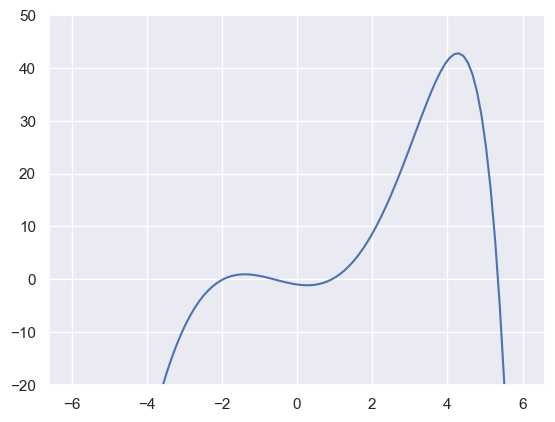

In [16]:
#Your function should look like this 
fig,ax = plt.subplots()
xx = np.linspace(-6, 6, 100)
ax.plot(xx, z(xx))
ax.set_ylim(-20, 50); 

## Question 3.a: Plot the Approximating 2nd-Order Polynomial

Recall that the 2nd-order Taylor approximation, $f(\theta)$, around a local point $\theta_0$ (in matrix notation) is given by

$$
f(\theta) = z(\theta_0) + g(\theta_0)(\theta - \theta_0)
+ \tfrac{1}{2} (\theta - \theta_0)' H(\theta_0) (\theta - \theta_0)
$$

When $z$ is just a regular scalar function, $z : \mathbb{R} \to \mathbb{R}$, this simplifies to

$$
f(\theta) = z(\theta_0) + z'(\theta_0)(\theta - \theta_0)
+ \tfrac{1}{2} z''(\theta_0)(\theta - \theta_0)^2
$$

> **Task:** Write the function `f_approx(theta, theta0)` implementing $f(\theta)$ for a given value of `theta0`.

**Hint:** Watch this video — [youtu.be/rzmRTCrNkk0](https://youtu.be/rzmRTCrNkk0)


In [21]:
def f_approx(theta, theta0): 
    # FILL IN 
    # a. find diff between thetha and theta0
    diff = theta-theta0
    # b. compute the first order term
    first = dz(theta0)*diff
    # c. compute second order term
    second = 0.5*ddz(theta0)*diff*diff

    # Evaluate the function, its first and second derivatives at theta0
    # then compute the approximated value and return it 
    f =  z(theta0)+ first + second
    return f 

When done, run the two cells below

In [22]:
# test your function 
assert f_approx(1.0, 1.0) == z(1.0), 'The function should be correct when evaluated at x=x0.'
assert np.isclose(f_approx(1.5, 1.0), 3.3335504283088744) 
# this should work if you used numerical first and second derivatives for z above

AssertionError: 

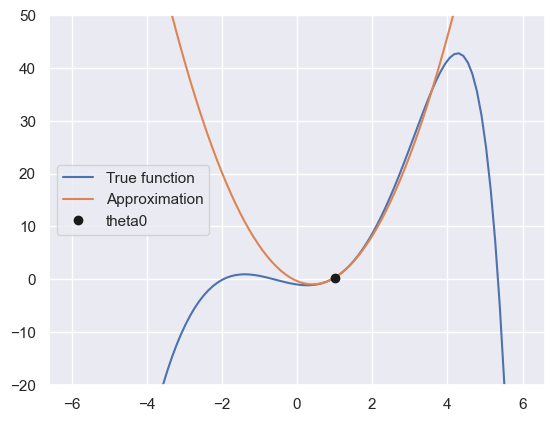

In [26]:
# this code will create a plot of your approximating function together with the true function

x0 = 1 # <--- try changing this 

xx = np.linspace(-6, 6, 100)
zz = np.empty(xx.shape)
ff = np.empty(xx.shape)

for i,x in enumerate(xx): 
    zz[i] = z(x)
    ff[i] = f_approx(x, x0)

fig,ax = plt.subplots(); 
ax.plot(xx, zz, label='True function')
ax.plot(xx, ff, label='Approximation')
ax.plot(x0,z(x0), 'ok', label='theta0')
ax.legend(loc='best')
ax.set_ylim(-20, 50); # ensures the plot isn't dancing around 

## Question 3.b: Run the algorithm for many different starting values

Maximize $z\left( \theta\right)$ (numerically) for
$\theta\in \left[-5,5\right]$ using the N-R algorithm. Use the starting
values $\theta_{0} \in \left\{ -5,-3,-1,0,1,3,5\right\}$. Do you find
local minima and maxima? What is the unique global maximum of
$z\left( \theta\right)$? Does the Newton-Raphson method fail to converge
to the global maximum? Why?


In [34]:
# We want to start from different start values
startvals = [-5.0, -3.0, -1.0, 0.0, 1.0, 3.0, 5.0]
n_vals = len(startvals)  # This is to help us to know how many start values to loop over
maxit = 100  # Max number of iterations
tolerance = 1e-8

# The following empty lists are to store the values achieved from the different starting points.
xopts     = np.zeros(n_vals)  # Store optimal x we reached
numevals  = np.zeros(n_vals)  # how many iterations it took
fvals     = np.zeros(n_vals)  # the function value we reached
gradients = np.zeros(n_vals)  # the gradient value we reached
hess      = np.zeros(n_vals)  # the hessian value we reached

Make a similar loop like we did for f(theta) in question 2.
You should have an outer loop, that loops over the different starting values.

In [39]:
for i, theta_start in enumerate(startvals):
    theta = theta_start  # keep the original start value separate
    for it in range(maxit):
        grad0 = dz(theta)    # gradient of z at current theta
        hess0 = ddz(theta)   # hessian of z at current theta

        # avoid division by (near) zero Hessian
        if abs(hess0) < 1e-12:
            print(f'Near-zero Hessian at start {theta_start} on iter {it}, stopping early.')
            break

        theta = theta - grad0 / hess0

        # use dz (not df) for the convergence criterion
        criterion = abs(dz(theta))
        if criterion <= tolerance:
            print(f'Tolerance satisfied on start {theta_start} on iteration {it}.')
            break

    if it == maxit-1 and criterion > tolerance:
        print(f'Error, reached maxit={maxit} without converging for start {theta_start}!')

    print(f'Start {theta_start}: Final theta: {theta:.6f}, grad = {dz(theta):.3g}, hess = {ddz(theta):.3g}, iters = {it+1}')

    # store results
    xopts[i]    = theta
    fvals[i]    = z(theta)
    gradients[i]= dz(theta)
    hess[i]     = ddz(theta)
    numevals[i] = it + 1


Tolerance satisfied on start -5.0 on iteration 5.
Start -5.0: Final theta: -1.392779, grad = 6.85e-10, hess = -4.61, iters = 6
Tolerance satisfied on start -3.0 on iteration 4.
Start -3.0: Final theta: -1.392779, grad = 2.28e-09, hess = -4.61, iters = 5
Tolerance satisfied on start -1.0 on iteration 4.
Start -1.0: Final theta: -1.392779, grad = 1.47e-15, hess = -4.61, iters = 5
Tolerance satisfied on start 0.0 on iteration 3.
Start 0.0: Final theta: 0.272610, grad = 8.11e-12, hess = 4.32, iters = 4
Tolerance satisfied on start 1.0 on iteration 3.
Start 1.0: Final theta: 0.272610, grad = 4.27e-09, hess = 4.32, iters = 4
Tolerance satisfied on start 3.0 on iteration 7.
Start 3.0: Final theta: -1.392779, grad = 8.59e-14, hess = -4.61, iters = 8
Tolerance satisfied on start 5.0 on iteration 4.
Start 5.0: Final theta: 4.276106, grad = -6.84e-11, hess = -42.3, iters = 5


In [40]:
# put results into a convenient dataframe
tab = pd.DataFrame({
    'x0': startvals, 
    'x':           xopts, 
    'f(x)':        fvals, 
    'gradient':    gradients, 
    'hessian':     hess, 
    'iterations':  numevals
})
tab.round(3)

,x0,x,f(x),gradient,hessian,iterations
0,-5.0,-1.393,0.930,0.0,-4.605,6.0
1,-3.0,-1.393,0.930,0.0,-4.605,5.0
2,-1.0,-1.393,0.930,0.0,-4.605,5.0
3,0.0,0.273,-1.144,0.0,4.322,4.0
4,1.0,0.273,-1.144,0.0,4.322,4.0
5,3.0,-1.393,0.930,0.0,-4.605,8.0
6,5.0,4.276,42.799,-0.0,-42.303,5.0


You should get something like this:

|    |   x0 |      x |   f(x) |   gradient |   hessian |   iterations |
|---:|-----:|-------:|-------:|-----------:|----------:|-------------:|
|  0 |   -5 | -1.393 |  0.93  |          0 |    -4.604 |            8 |
|  1 |   -3 | -1.393 |  0.93  |         -0 |    -4.605 |            6 |
|  2 |   -1 | -1.393 |  0.93  |         -0 |    -4.608 |            4 |
|  3 |    0 |  0.273 | -1.144 |          0 |     4.311 |            7 |
|  4 |    1 |  0.273 | -1.144 |          0 |     4.344 |            5 |
|  5 |    3 | -1.393 |  0.93  |         -0 |    -4.607 |            8 |
|  6 |    5 |  4.276 | 42.799 |          0 |   -42.316 |            6 |

If you filled out `tab` correctly, you can create the figure below to visualize where the algorithm ends up for each starting value. 

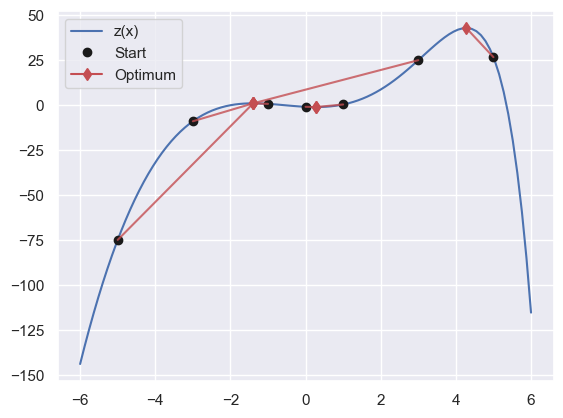

In [41]:
xx = np.linspace(-6,6,100)
fig,ax = plt.subplots()

ax.plot(xx, z(xx)); # plot the function 

# show visually the connection between starting point and ending value 
for i,x0 in enumerate(startvals): 
    z0 = z(x0)            # evaluate at starting values 
    x = tab.iloc[i].x     # where the optimizer went to 
    ax.plot(x0,z0,'ok')   # draw starting value
    ax.plot(x,z(x),'-dr') # draw converged value 
    ax.plot([x0,x], [z0,z(x)], '-r', alpha=.8) # line connecting the two points

ax.legend(['z(x)', 'Start', 'Optimum'], loc='best'); 

## Question 3.c: Intuition

The function $z(\theta)$ clearly has three stationary points: -1.393, 0.273, and 4.276. 

* Classify the points as local vs. global, and maxima vs. minima. 

* Why is the global optimum so hard to find? When we start at $\theta_0 = 3.0$, we end up quite far away and move in the wrong direction (gasp!), why? 

# Question 4: Write it as a function 

Write a function `minimize(Q, theta0, maxit, tol)`, where the inputs are 
* `Q`: a function handle, 
* `theta0`: a starting value, 
* `maxit`: max no. iterations, 
* `tol`: the tolerance determining when to exit. 

and the output should be the value of `theta`, where `Q` attains its minimum. 

Check that your minimizer on these functions: 
$$ 
\begin{aligned} 
Q(\theta) &= \frac{1}{\theta} + \exp(\theta), \quad &\theta \in [0.1; 3], \theta_0 = 3. \\ 
Q(\theta) &= \cos(\theta), \quad &\theta \in [0; 2 \pi], \theta_0 = 3. \\ 
\end{aligned}
$$

Investigate what happens if you change the starting value, $\theta_0$. Can you make the optimizer fail (based on inspecting the function graphically and what you know about N-R)? 

As an extra exercise, try writing the two functions in separate `.py` files, `Q1.py` and `Q2.py` and importing them instead of using `lambda` functions. (Later in the course, we will only be importing.) 

***Hints:*** 
* Since `Q` is an input to `minimize`, we must create the derivative functions (using `forward_diff()`) inside of our function as lambda functions. 
* Remember to print some output if the minimizer hits the max no. iterations without converging. 

In [50]:
def minimize(Q, theta_start, maxit=100, tolerance=1e-8, h=h, l = l): 
    '''minimize: Newton-Raphson algorithm for a general function input, f. 
    '''
    
    # set up numerical derivative functions 
    dQ  =  est.forward_diff(Q) # fill in
    ddQ = est.forward_diff(dQ) # fill in
    
    # initialize 
    theta0 = theta_start # to avoid writing to inputs later on  
    
    # primary algorithm loop 
    for it in range(maxit): 
        
        # Fill in update step for theta 
        grad0 = dQ(theta0)
        hess0 = ddQ(theta0)

        # avoid division by (near) zero Hessian
        if abs(hess0) < 1e-12:
            print(f'Near-zero Hessian at start {theta_start} on iter {it}, stopping early.')
            break

        theta0 = theta0 - grad0 / hess0

        # check convergence 
        criterion = abs(dQ(theta0))
        if criterion <= tolerance:
            print(f'Tolerance satisfied on iteration {it}.')
            break
        
        # update previous theta
        theta0 = theta

    if it == maxit-1: 
        print(f'Warning: non-convergence after {maxit} it., theta is {theta:8.4g}.')
    
    return theta

In [51]:
def plot_result(Q, theta_star, theta_low, theta_high): 
    '''plot_result: plots your Q function over the interval and adds a dot for theta_star'''
    fig,ax = plt.subplots(); 
    tt = np.linspace(theta_low,theta_high,100)
    ax.plot(tt, Q(tt), '-', label='Q');
    ax.plot(theta_star, Q(theta_star), 'or', label='Optimum');
    ax.legend(); 

## Question 4a
$$ Q(\theta) = \frac{1}{\theta} + \exp(\theta), \quad \theta \in [0.1; 3], \theta_0 = 3. $$

Explicitly: we want you to create a file named Q1.py and implement the above function. Make sure the file is in the same folder as this file.

In [55]:
import Q1 as Q1            # requires there to be a file "Q1.py" in this directory
theta0 = 3.0          # once it works, try changing the starting value (inside [0.1;3.0])
Q1.Q(theta0)         # Q1.py must have a function named "Q" 
theta_star = Q1.minimize(Q1.Q, theta0)
plot_result(Q1.Q, theta_star, 0.1, 3.0)

TypeError: 'numpy.float64' object is not callable

## Question 4b
$$Q(\theta) = \cos(\theta), \quad \theta \in [0; 2 \pi], \theta_0 = 3. $$

Explicitly: we want you to create a file named Q2.py and implement the above function. Make sure the file is in the same folder as this file.

Tolerance satisfied on iteration 2.


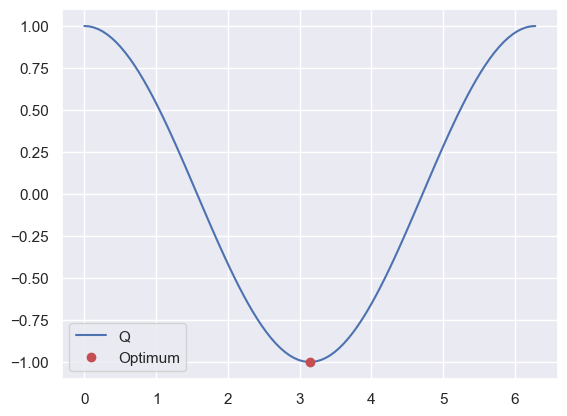

In [6]:
from Q2 import Q
theta0 = 3.0
Q(theta0) # checking that your function works
theta_star = minimize(Q, theta0)
plot_result(Q, theta_star, 0., 2*np.pi)

# Question 5: A Tricky Example

Try your optimizer on the hyperbolic cosine function:

$$
Q(\theta) = \cosh(\theta), \quad \theta \in [-5, 5], \quad \theta_0 = 1
$$

Verify that the optimizer fails to converge (finds flat gradients), but that the gradients are indeed flat at `theta = 0.0`.

Try changing the following to see what remedies the situation:

- `maxit`: does more iterations help?
- `h`: finer or coarser step sizes?
- `theta0`: look at the graph and think of a starting value that should help.

In [7]:
Q = lambda theta : np.cosh(theta)

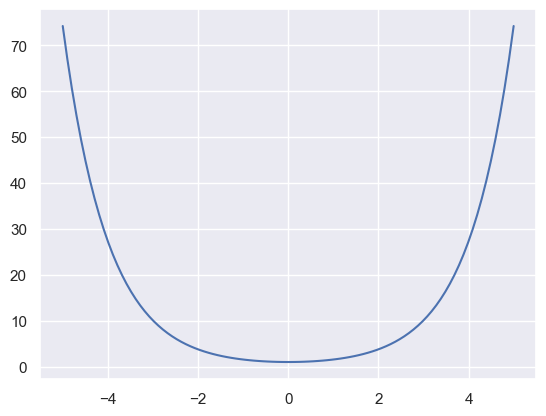

In [8]:
# have a look at the function 
xx = np.linspace(-5,5,100)
plt.plot(xx, Q(xx)); 

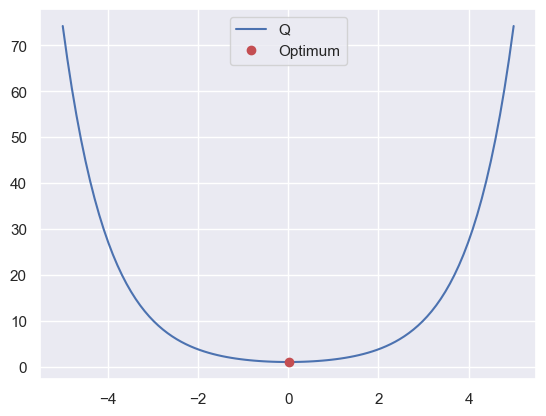

In [9]:
theta_star = minimize(Q, 1.0)
plot_result(Q, theta_star, -5., 5.)

In [10]:
# check gradient is zero
dQ = lambda theta : est.forward_diff(Q, theta)
ddQ = lambda theta : est.forward_diff(dQ, theta, h=1e-4)

print(f'Gradients at final point: {dQ(theta_star)}')
print(f'Hessian = {ddQ(theta_star)}')

Gradients at final point: 0.02851223887657754
Hessian = 1.200001398474251


Tolerance satisfied on iteration 207.
theta_star=-7.727755724380551e-05, with grad = -0.0


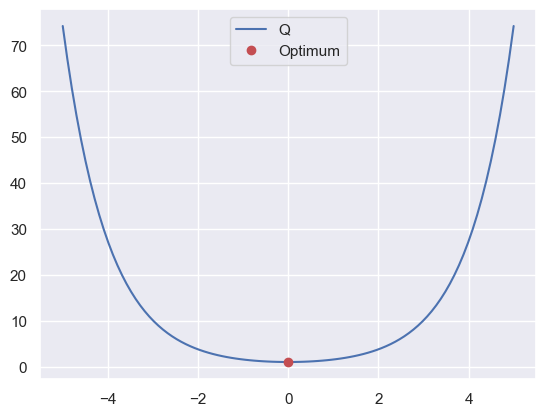

In [11]:
Q = lambda theta : np.cosh(theta)
theta_star = minimize(Q, 1.0, l=1e-4, maxit=1000) # raise the number of iterations, maxit, and outer step size, l
plot_result(Q, theta_star, -5., 5.)
print(f'{theta_star=}, with grad = {dQ(theta_star)}')